# WORD2VEC LSTM on Quora Question Pairs

This notebook is about implementing the LSTM model on Kaggle's Quora Question Pairs data using Word2Vec embeddings.

# CODE

First, lets import all the necessary packages

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, Lambda, Dropout
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

Global variables

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# File paths
TRAIN_CSV = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/cleantext/bert/bctrain.csv'
TEST_CSV = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/cleantext/bert/bcdev.csv'
EMBEDDING_FILE = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/googlenews/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/'

In [4]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Create embedding matrix

In [5]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

In [6]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

#stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    text = text.split()

    return text

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.at[index, question] = q2n
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del(word2vec)

Prepare training and validation data

In [7]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [8]:
Y_test = test_df['is_duplicate'].values
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

Y_test.shape, X_test['left'].shape, X_test['right'].shape, len(X_test['right'])

((40430,), (40430, 216), (40430, 216), 40430)

Build the model

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = metrics.confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [10]:
def print_modelpred_metrics(y_test,y_pred):
    prediction = np.round(abs(y_pred))
    print ('Accuracy:  ', accuracy_score(y_test, prediction))
    print ('F1 score:  ', f1_score(y_test, prediction))
    print ('Recall:    ', recall_score(y_test, prediction))
    print ('Precision: ', precision_score(y_test, prediction))
    print ('\nclasification report:\n\n', classification_report(y_test,prediction))
    print ('\n confussion matrix:\n\n',confusion_matrix(y_test, prediction))

In [ ]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

import tensorflow as tf

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)
outputs = Dense(64, activation='relu')(concat_outputs)
prob = Dense(1, activation='sigmoid')(outputs)


# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(learning_rate=0.001)

malstm = Model([left_input, right_input], prob)

malstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=0, mode='auto')

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
4429/4429 [==============================] - 92s 20ms/step - loss: 0.4533 - accuracy: 0.7765 - val_loss: 0.4162 - val_accuracy: 0.8021
Epoch 2/20
4429/4429 [==============================] - 87s 20ms/step - loss: 0.3838 - accuracy: 0.8198 - val_loss: 0.3812 - val_accuracy: 0.8216
Epoch 3/20
4429/4429 [==============================] - 87s 20ms/step - loss: 0.3501 - accuracy: 0.8389 - val_loss: 0.3712 - val_accuracy: 0.8272
Epoch 4/20
4429/4429 [==============================] - 86s 20ms/step - loss: 0.3254 - accuracy: 0.8526 - val_loss: 0.3782 - val_accuracy: 0.8280
Epoch 5/20
4429/4429 [==============================] - 87s 20ms/step - loss: 0.3064 - accuracy: 0.8631 - val_loss: 0.3621 - val_accuracy: 0.8357
Epoch 6/20
4429/4429 [==============================] - 86s 19ms/step - loss: 0.2897 - accuracy: 0.8714 - val_loss: 0.3678 - val_accuracy: 0.8354
Epoch 7/20
4429/4429 [==============================] - 87s 20ms/step - loss: 0.2746 - accuracy: 0.8792 - val_loss: 0.3765 -

In [ ]:
y_pred = malstm.predict([X_test['left'], X_test['right']])

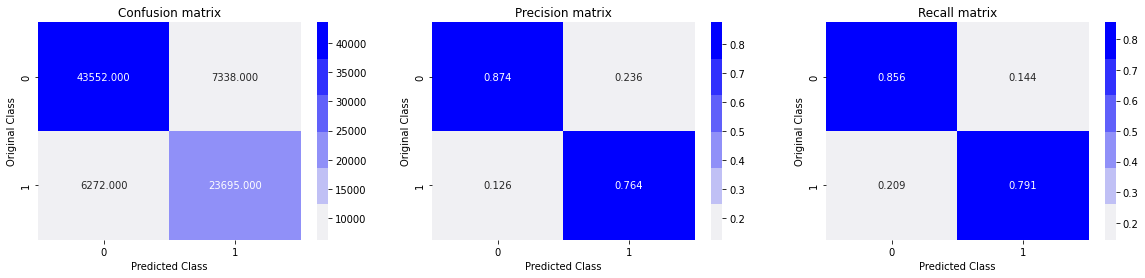

In [ ]:
plot_confusion_matrix(Y_test, np.round(abs(y_pred)))

In [ ]:

prediction = np.round(abs(y_pred))
print ('Accuracy:  ', accuracy_score(Y_test, prediction))
print ('F1 score:  ', f1_score(Y_test, prediction))
print ('Recall:    ', recall_score(Y_test, prediction))
print ('Precision: ', precision_score(Y_test, prediction))
print ('\nclasification report:\n\n', classification_report(Y_test,prediction))
print ('\n confussion matrix:\n\n',confusion_matrix(Y_test, prediction))

Accuracy:   0.8316781478412506
F1 score:   0.7768852459016394
Recall:     0.7907031067507592
Precision:  0.7635420358972707

clasification report:

               precision    recall  f1-score   support

           0       0.87      0.86      0.86     50890
           1       0.76      0.79      0.78     29967

    accuracy                           0.83     80857
   macro avg       0.82      0.82      0.82     80857
weighted avg       0.83      0.83      0.83     80857


 confussion matrix:

 [[43552  7338]
 [ 6272 23695]]


In [11]:
# Model variables
n_lstm = 100
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

import tensorflow as tf

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_lstm)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)
outputs = Dense(64, activation='relu')(concat_outputs)
outputs = Dense(32, activation='relu')(outputs)
prob = Dense(1, activation='sigmoid')(outputs)


# Adam optimizer
optimizer = Adam(learning_rate=0.001)

qqplstm = Model([left_input, right_input], prob)

qqplstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=0, mode='auto')

qqplstm_trained = qqplstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
5061/5061 [==============================] - 135s 25ms/step - loss: 0.4389 - accuracy: 0.7859 - val_loss: 0.3916 - val_accuracy: 0.8142
Epoch 2/20
5061/5061 [==============================] - 124s 24ms/step - loss: 0.3603 - accuracy: 0.8340 - val_loss: 0.3646 - val_accuracy: 0.8303
Epoch 3/20
5061/5061 [==============================] - 124s 24ms/step - loss: 0.3172 - accuracy: 0.8577 - val_loss: 0.3541 - val_accuracy: 0.8405
Epoch 4/20
5061/5061 [==============================] - 124s 24ms/step - loss: 0.2834 - accuracy: 0.8760 - val_loss: 0.3522 - val_accuracy: 0.8426
Epoch 5/20
5061/5061 [==============================] - 123s 24ms/step - loss: 0.2552 - accuracy: 0.8904 - val_loss: 0.3645 - val_accuracy: 0.8422
Epoch 6/20
5061/5061 [==============================] - 123s 24ms/step - loss: 0.2293 - accuracy: 0.9028 - val_loss: 0.3665 - val_accuracy: 0.8421
Epoch 7/20
5061/5061 [==============================] - 124s 25ms/step - loss: 0.2064 - accuracy: 0.9136 - val_loss: 0

In [12]:
y_pred1 = qqplstm.predict([X_test['left'], X_test['right']])

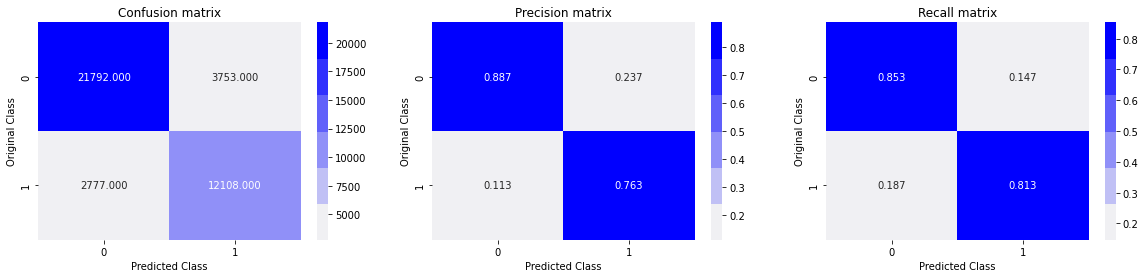

In [14]:
prediction1 = np.round(abs(y_pred1))
plot_confusion_matrix(Y_test, prediction1)

In [15]:
print_modelpred_metrics(Y_test,prediction1)

Accuracy:   0.8384862725698738
F1 score:   0.7876146490600405
Recall:     0.8134363453140746
Precision:  0.763381880083223

clasification report:

               precision    recall  f1-score   support

           0       0.89      0.85      0.87     25545
           1       0.76      0.81      0.79     14885

    accuracy                           0.84     40430
   macro avg       0.83      0.83      0.83     40430
weighted avg       0.84      0.84      0.84     40430


 confussion matrix:

 [[21792  3753]
 [ 2777 12108]]


In [25]:
y = pd.DataFrame(data=test_df.is_duplicate)

In [27]:
test1_df = pd.read_csv(TEST_CSV)

In [28]:
y_test1 = y.copy()
y_test1['pred_prob'] = y_pred1
y_test1['rounded_pred'] = prediction1
mergedf = pd.merge(test1_df[['question1','question2']], y_test1, left_index = True, right_index = True)
mergedf.to_csv('qqp_word2vec_lstm_predicted_output.csv')

In [ ]:
# Model variables
n_lstm = 128
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_lstm)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)

outputs = Dense(128, activation='relu')(concat_outputs)
outputs = Dropout(0.2)(outputs)

outputs = Dense(64, activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)

prob = Dense(1, activation='sigmoid')(outputs)


# Adam optimizer
optimizer = Adam(learning_rate=0.001)

qqplstm1 = Model([left_input, right_input], prob)

qqplstm1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=0, mode='auto')

qqplstm1_trained = qqplstm1.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
4429/4429 [==============================] - 124s 27ms/step - loss: 0.4482 - accuracy: 0.7809 - val_loss: 0.4166 - val_accuracy: 0.7990
Epoch 2/20
4429/4429 [==============================] - 120s 27ms/step - loss: 0.3707 - accuracy: 0.8283 - val_loss: 0.3679 - val_accuracy: 0.8302
Epoch 3/20
4429/4429 [==============================] - 120s 27ms/step - loss: 0.3252 - accuracy: 0.8533 - val_loss: 0.3529 - val_accuracy: 0.8390
Epoch 4/20
4429/4429 [==============================] - 120s 27ms/step - loss: 0.2870 - accuracy: 0.8731 - val_loss: 0.3495 - val_accuracy: 0.8429
Epoch 5/20
4429/4429 [==============================] - 120s 27ms/step - loss: 0.2528 - accuracy: 0.8899 - val_loss: 0.3550 - val_accuracy: 0.8466
Epoch 6/20
4429/4429 [==============================] - 120s 27ms/step - loss: 0.2228 - accuracy: 0.9050 - val_loss: 0.3745 - val_accuracy: 0.8439
Epoch 7/20
4429/4429 [==============================] - 120s 27ms/step - loss: 0.1970 - accuracy: 0.9179 - val_loss: 0

In [ ]:
y_pred2 = qqplstm1.predict([X_test['left'], X_test['right']])

print_modelpred_metrics(Y_test,y_pred2)

Accuracy:   0.8439096182148732
F1 score:   0.7886248304275737
Recall:     0.785664230653719
Precision:  0.7916078273149082

clasification report:

               precision    recall  f1-score   support

           0       0.87      0.88      0.88     50890
           1       0.79      0.79      0.79     29967

    accuracy                           0.84     80857
   macro avg       0.83      0.83      0.83     80857
weighted avg       0.84      0.84      0.84     80857


 confussion matrix:

 [[44692  6198]
 [ 6423 23544]]


In [ ]:
# Model variables
n_lstm = 256
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_lstm)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)

outputs = Dense(256, activation='relu')(concat_outputs)
outputs = Dropout(0.2)(outputs)

outputs = Dense(128, activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)

prob = Dense(1, activation='sigmoid')(outputs)


# Adam optimizer
optimizer = Adam(learning_rate=0.001)

qqplstm2 = Model([left_input, right_input], prob)

qqplstm2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=0, mode='auto')

qqplstm2_trained = qqplstm2.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
4429/4429 [==============================] - 206s 46ms/step - loss: 0.4814 - accuracy: 0.7606 - val_loss: 0.4245 - val_accuracy: 0.8008
Epoch 2/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.3886 - accuracy: 0.8174 - val_loss: 0.3761 - val_accuracy: 0.8255
Epoch 3/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.3338 - accuracy: 0.8487 - val_loss: 0.3583 - val_accuracy: 0.8389
Epoch 4/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.2821 - accuracy: 0.8760 - val_loss: 0.3714 - val_accuracy: 0.8383
Epoch 5/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.2331 - accuracy: 0.9008 - val_loss: 0.3838 - val_accuracy: 0.8450
Epoch 6/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.1897 - accuracy: 0.9218 - val_loss: 0.3949 - val_accuracy: 0.8457
Epoch 7/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.1547 - accuracy: 0.9374 - val_loss: 0

In [ ]:
y_pred3 = qqplstm2.predict([X_test['left'], X_test['right']])

print_modelpred_metrics(Y_test,y_pred3)

Accuracy:   0.8460986680188481
F1 score:   0.7874419240229571
Recall:     0.7691794307071111
Precision:  0.8065927144206879

clasification report:

               precision    recall  f1-score   support

           0       0.87      0.89      0.88     50890
           1       0.81      0.77      0.79     29967

    accuracy                           0.85     80857
   macro avg       0.84      0.83      0.83     80857
weighted avg       0.85      0.85      0.85     80857


 confussion matrix:

 [[45363  5527]
 [ 6917 23050]]
